In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
data = pd.read_json('cmpt-history.ndjson.gz', lines=True, convert_dates=['date'])

# Filtering: We don't need CHIN & DDP courses, co-op courses, research courses, or graduate level courses. We can filter these out
# Note: Even though research project courses can be full, we omit the courses as it is too dependent on non-quantifiable factors (eg: research topic, professor, etc.)
data = data.loc[data['subject'].apply(lambda x: x == 'CMPT' or x == 'MACM')] # Filtering non-CMPT or MACM courses
data = data.loc[data['number'].apply(lambda x: int(x[:3])<500)] # Filtering graduate-level courses, note: [:3] is to avoid edge cases such as 105W
data = data.loc[data['number'].apply(lambda x: int(x[:3]) < 426 or int(x[:3]) > 430)] # Filtering co-op courses
data = data.loc[data['number'].apply(lambda x: int(x[:3]) < 415 or int(x[:3]) > 416)] # Filtering research courses
data

,semester,subject,number,section,campus,component,instr_mode,date,enrl_cap,enrl_tot,wait_tot
17,1241,CMPT,105W,D100,BRNBY,CAN,P,2023-08-11,200,0,0
18,1241,CMPT,105W,D100,BRNBY,CAN,P,2023-09-10,200,0,0
19,1241,CMPT,105W,D100,BRNBY,CAN,P,2023-10-10,200,0,0
20,1241,CMPT,105W,D200,BRNBY,LEC,P,2023-08-11,200,94,27
21,1241,CMPT,105W,D200,BRNBY,LEC,P,2023-09-10,200,94,27
...,...,...,...,...,...,...,...,...,...,...,...
66003,1171,CMPT,497,D100,BRNBY,SEC,P,2017-03-03,5,3,0
66046,1171,MACM,101,D100,BRNBY,LEC,P,2017-03-03,175,157,0
66047,1171,MACM,101,D100,BRNBY,LEC,P,2017-05-05,175,157,0
66048,1171,MACM,101,D200,BRNBY,LEC,P,2017-03-03,175,173,0


In [8]:
# Test: Graphing the enrollment data of CMPT 433
testData = data.loc[data['number'] == '353']
# testData = testData.loc[testData['semester'] == 1237]
testData = testData.sort_values(by=['date'])
testData


,semester,subject,number,section,campus,component,instr_mode,date,enrl_cap,enrl_tot,wait_tot
57034,1184,CMPT,353,D100,BRNBY,LEC,P,2018-01-17,110,99,0
57035,1184,CMPT,353,D100,BRNBY,LEC,P,2018-02-28,110,99,0
57036,1184,CMPT,353,D100,BRNBY,LEC,P,2018-03-06,110,99,0
57037,1184,CMPT,353,D100,BRNBY,LEC,P,2018-03-07,110,99,0
57038,1184,CMPT,353,D100,BRNBY,LEC,P,2018-03-08,110,99,0
...,...,...,...,...,...,...,...,...,...,...,...
311,1241,CMPT,353,E100,BRNBY,LEC,P,2023-11-16,150,150,15
312,1241,CMPT,353,E100,BRNBY,LEC,P,2023-11-17,150,150,15
313,1241,CMPT,353,E100,BRNBY,LEC,P,2023-11-18,150,150,15
314,1241,CMPT,353,E100,BRNBY,LEC,P,2023-11-20,150,150,15


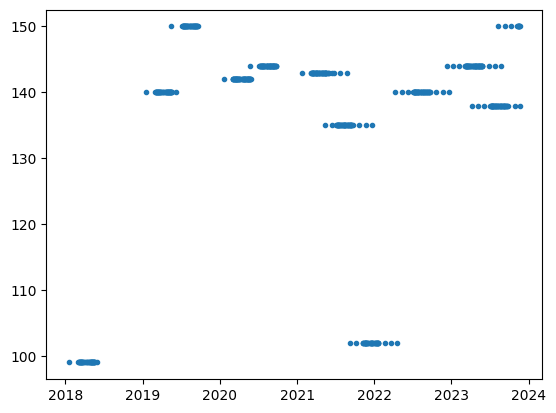

In [9]:
plt.plot(testData['date'], testData['enrl_tot'], '.')
